<h1>NAMA : DENI PRIYADI
<h1> NIM : 191410038
<H1> Alamat : Kabupaten Majalengka

In [ ]:
import zipfile
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/DICODING/DATASET/Air Pollution Forecasting - LSTM Multivariate/LSTM-Multivariate_pollution.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43800 entries, 0 to 43799
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       43800 non-null  object 
 1   pollution  43800 non-null  float64
 2   dew        43800 non-null  int64  
 3   temp       43800 non-null  float64
 4   press      43800 non-null  float64
 5   wnd_dir    43800 non-null  object 
 6   wnd_spd    43800 non-null  float64
 7   snow       43800 non-null  int64  
 8   rain       43800 non-null  int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 3.0+ MB


In [ ]:
df.head()

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [ ]:
df.tail()

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
43795,2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43796,2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43797,2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43798,2014-12-31 22:00:00,8.0,-22,-4.0,1034.0,NW,246.72,0,0
43799,2014-12-31 23:00:00,12.0,-21,-3.0,1034.0,NW,249.85,0,0


In [ ]:
df = df.drop(['dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain'], axis=1)

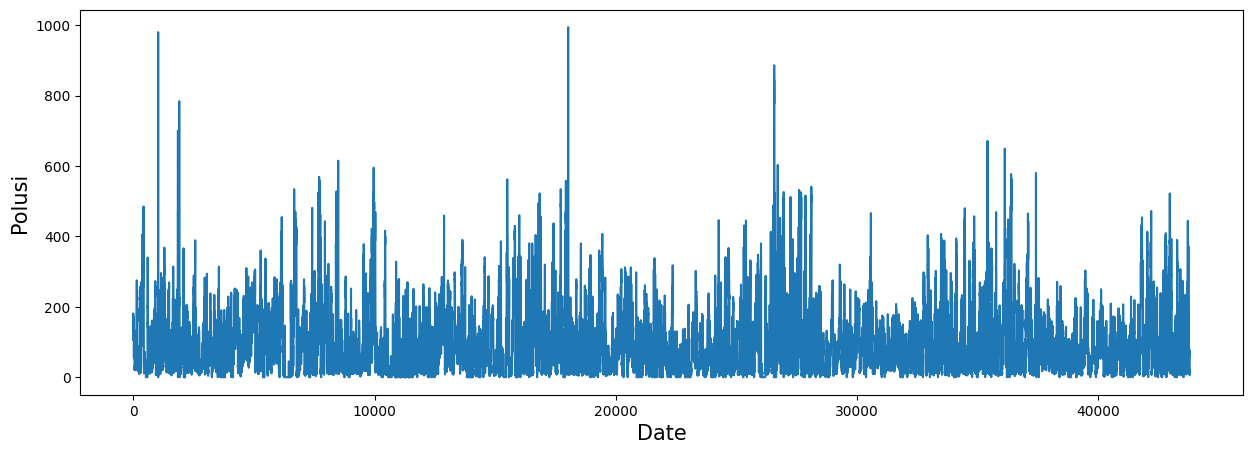

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(df['pollution'])
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Polusi', fontsize = 15)
plt.show()

In [ ]:
df['date'] = pd.to_datetime(df['date'])

# Set 'tanggal' as the index
df.set_index('date', inplace=True)
new_df2 = df.resample('D').mean()

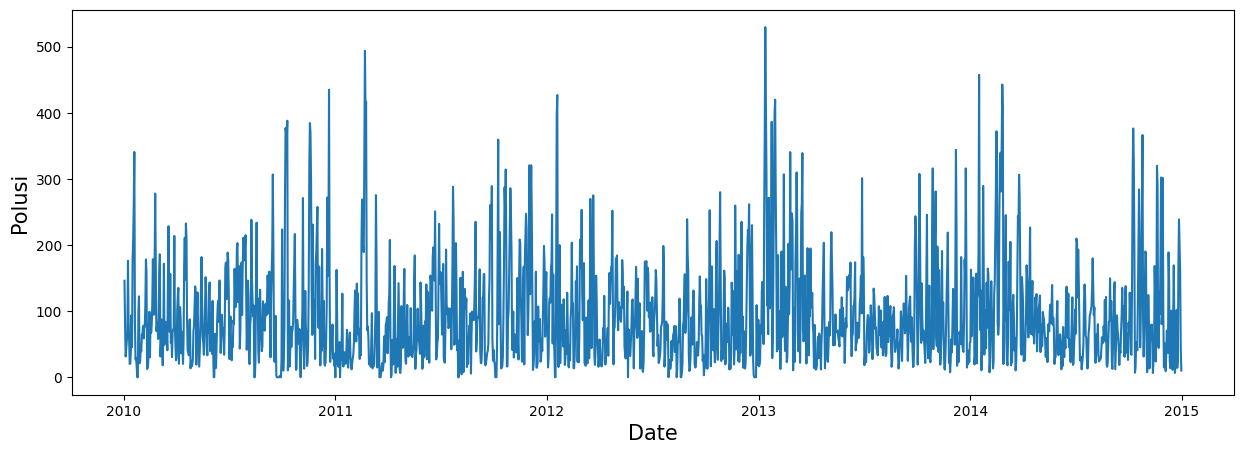

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(new_df2['pollution'])
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Polusi', fontsize = 15)
plt.show()

In [ ]:
scaller = MinMaxScaler(feature_range=(0,1))
new_df2[new_df2.columns] = scaller.fit_transform(new_df2)

In [ ]:
new_df2

,pollution
date,
2010-01-02,0.275675
2010-01-03,0.148894
2010-01-04,0.059180
2010-01-05,0.080192
2010-01-06,0.106555
...,...
2014-12-27,0.450775
2014-12-28,0.372787
2014-12-29,0.300307


In [ ]:
train = round(len(new_df2)* 0.80)
train

1460

In [ ]:
data_train = new_df2[:train]
data_test  = new_df2[train:]

In [ ]:
def urutan_train_test(dataset):
                sequence = []
                label = []
                start_index = 0
                for stop_index in range(50,len(dataset)):
                    sequence.append(dataset.iloc[start_index:stop_index])
                    label.append(dataset.iloc[stop_index])
                    start_index += 1
                return (np.array(sequence),np.array(label))

train_data, label_data = urutan_train_test(data_train)
test_data, label_test = urutan_train_test(data_test)

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(30, input_shape=(train_data.shape[1], 1), return_sequences=True),
    tf.keras.layers.LSTM(16),
    tf.keras.layers.Dense(5, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_48 (LSTM)              (None, 50, 30)            3840      
                                                                 
 lstm_49 (LSTM)              (None, 16)                3008      
                                                                 
 dense_71 (Dense)            (None, 5)                 85        
                                                                 
 dense_72 (Dense)            (None, 1)                 6         
                                                                 
Total params: 6939 (27.11 KB)
Trainable params: 6939 (27.11 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('mae') <= 0.05:
            print("MAE sudah mencapai threshold")
            self.model.stop_training = True

In [ ]:
model.compile(loss=tf.keras.losses.Huber(),
              optimizer='adam',
              metrics=["mae"])

In [ ]:
history = model.fit(train_data,
                    label_data,
                    epochs=25,
                    validation_data=(test_data, label_test),
                    batch_size = 64,
                    callbacks=[myCallback()])

Epoch 1/25
23/23 [==============================] - 6s 85ms/step - loss: 0.0136 - mae: 0.1237 - val_loss: 0.0102 - val_mae: 0.1051
Epoch 2/25
23/23 [==============================] - 1s 44ms/step - loss: 0.0104 - mae: 0.1081 - val_loss: 0.0102 - val_mae: 0.1046
Epoch 3/25
23/23 [==============================] - 1s 48ms/step - loss: 0.0103 - mae: 0.1089 - val_loss: 0.0102 - val_mae: 0.1041
Epoch 4/25
23/23 [==============================] - 1s 46ms/step - loss: 0.0103 - mae: 0.1079 - val_loss: 0.0101 - val_mae: 0.1054
Epoch 5/25
23/23 [==============================] - 1s 48ms/step - loss: 0.0102 - mae: 0.1084 - val_loss: 0.0101 - val_mae: 0.1031
Epoch 6/25
23/23 [==============================] - 1s 61ms/step - loss: 0.0102 - mae: 0.1075 - val_loss: 0.0100 - val_mae: 0.1037
Epoch 7/25
23/23 [==============================] - 2s 75ms/step - loss: 0.0101 - mae: 0.1089 - val_loss: 0.0101 - val_mae: 0.1016
Epoch 8/25
23/23 [==============================] - 2s 75ms/step - loss: 0.0104 - m

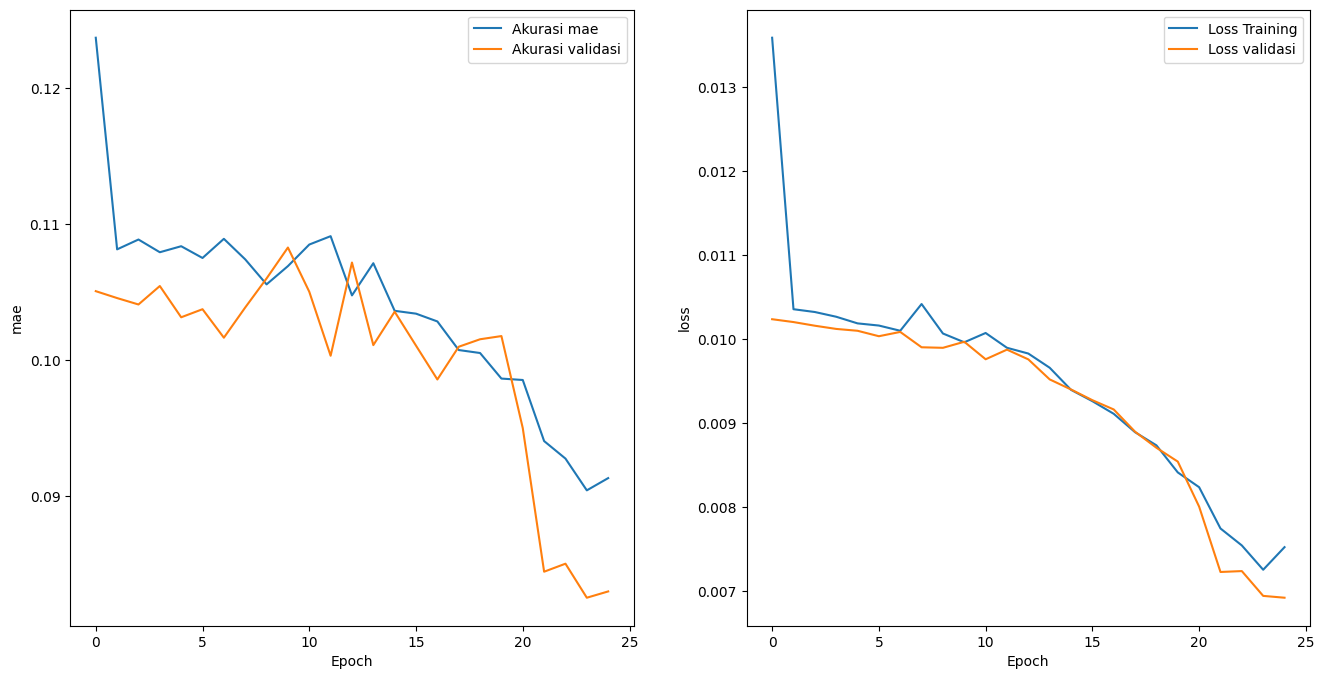

In [ ]:
%matplotlib inline

import matplotlib.image as mimg
import matplotlib.pyplot as plt

mae = (history.history['mae'])
val_mae = (history.history['val_mae'])
loss = (history.history['loss'])
val_loss = (history.history['val_loss'])

plt.figure(figsize = (16,8))
plt.subplot(1,2,1)

plt.plot(mae, label = 'Akurasi mae')
plt.plot(val_mae, label = 'Akurasi validasi')
plt.title = ('mae and Validation mae')
plt.xlabel('Epoch')
plt.ylabel('mae')
plt.legend(loc = 'upper right')

plt.subplot(1,2,2)
plt.plot(loss, label = 'Loss Training')
plt.plot(val_loss, label = 'Loss validasi')
plt.title = ('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc = 'upper right')

plt.show()